# Quadgrid
The `quadgrid` package provides a class and some convenience functions 
for generating quadtree-based grids at arbitrary resolutions in pandas, geopandas and xarray formats for use in geospatial analysis and catastrophe risk modelling. 

## Overview
Quadtree grids are a way of recursively partitioning a plane into
nested quadrants, allowing for simple but efficient geocoding of
points.

Some assumptions have been made to simplify the package:
- all coordinates are in decimal degrees
- all longitudes range from -180 to +180 degrees
- the centre of the grid is at 0E, 0N

The package contains a single class, `QuadGrid`, which is used to
generate grid objects. The class has methods to convert the grid into
tabular (pandas DataFrame), vector (geopandas GeoDataFrame) and raster
(xarray Dataset) formats which can be saved or used in further processing.

Individual quadcells at a given resolution are labelled with unique
quadtreeIDs (qids). In the simplified example below, the red point is in top-level cell '2', then cell '2', then '0' then '3' giving a nominal qid of '2203'. In practice, quadtrees lend themselves to a base-4 encoding, allowing them to be stored and processed efficiently as integers.

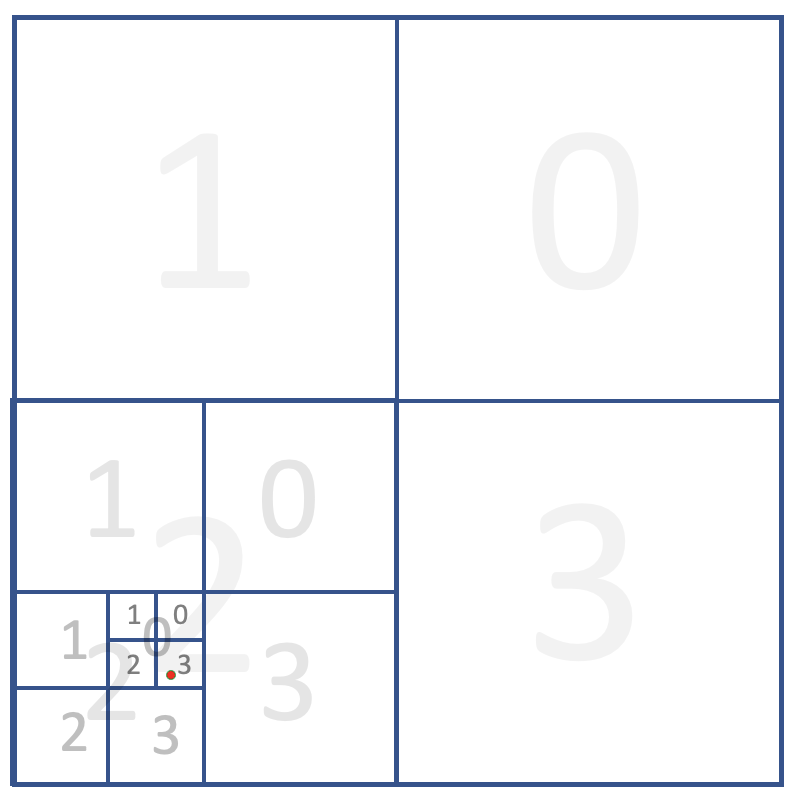

## Versions
`0.1.0` First release

## Examples

In [1]:
import quadgrid as qg
import matplotlib.pyplot as plt
import geopandas as gpd

Load low resolution Natural Earth shapefiles from geopandas for demonstrations.

In [2]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_geom = world.dissolve().loc[0,'geometry']
uk_geom = world.set_index('iso_a3').loc['GBR','geometry']

/var/folders/_c/rp75w5gn0350fmjtsw645xqc0000gs/T/ipykernel_38026/2235393568.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


### Global low-resolution grid

Create global quadgrid at 1.0$^{\circ}$ resolution:

In [3]:
q100_world = qg.QuadGrid(0.25)
q100_world

QuadGrid (0.25) -180<=lon<=180 | -90<=lat<=90

Apply a shapely geometry object (either a Polygon or MultiPolygon) as a mask, in this case the dissolved country shapefile:

In [4]:
q100_world.apply_mask(world_geom)

In [5]:
q100_world_pd = q100_world.to_pandas()
q100_world_pd

qid      area   mask
lat     lon                               
-89.875 -179.875  2583658  1.685923   True
        -179.625  2583659  1.685923   True
        -179.375  2583662  1.685923   True
        -179.125  2583663  1.685923   True
        -178.875  2583674  1.685923   True
...                   ...       ...    ...
 89.875  178.875   902864  1.685923  False
         179.125   902853  1.685923  False
         179.375   902852  1.685923  False
         179.625   902849  1.685923  False
         179.875   902848  1.685923  False

[1036800 rows x 3 columns]

In [6]:
q100_world_xr = q100_world.to_xarray()
q100_world_xr

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Data variables:
    qid      (lat, lon) int64 2583658 2583659 2583662 ... 902852 902849 902848
    area     (lat, lon) float64 1.686 1.686 1.686 1.686 ... 1.686 1.686 1.686
    mask     (lat, lon) bool True True True True ... False False False False
Attributes:
    Type:        quadgrid
    Resolution:  0.25
    Area units:  km2

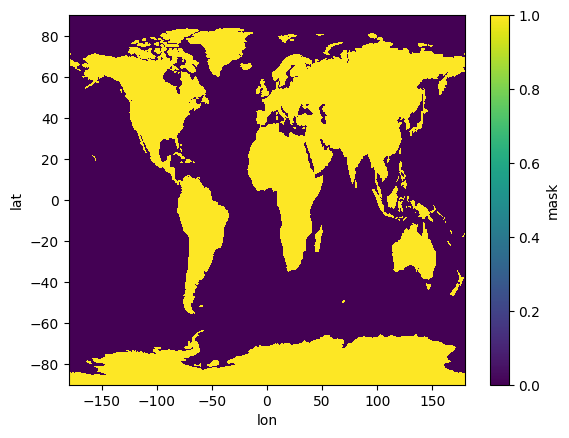

In [7]:
q100_world_xr['mask'].plot();

In [8]:
q100_world_gpd = q100_world.to_geopandas()
q100_world_gpd

,lat,lon,qid,area,mask,geometry
0,-89.875,-179.875,2583658,1.685923,True,"POLYGON ((-179.75000 -89.75000, -179.75000 -90..."
1,-89.875,-179.625,2583659,1.685923,True,"POLYGON ((-179.50000 -89.75000, -179.50000 -90..."
2,-89.875,-179.375,2583662,1.685923,True,"POLYGON ((-179.25000 -89.75000, -179.25000 -90..."
3,-89.875,-179.125,2583663,1.685923,True,"POLYGON ((-179.00000 -89.75000, -179.00000 -90..."
4,-89.875,-178.875,2583674,1.685923,True,"POLYGON ((-178.75000 -89.75000, -178.75000 -90..."
...,...,...,...,...,...,...
1036795,89.875,178.875,902864,1.685923,False,"POLYGON ((179.00000 90.00000, 179.00000 89.750..."
1036796,89.875,179.125,902853,1.685923,False,"POLYGON ((179.25000 90.00000, 179.25000 89.750..."
1036797,89.875,179.375,902852,1.685923,False,"POLYGON ((179.50000 90.00000, 179.50000 89.750..."
1036798,89.875,179.625,902849,1.685923,False,"POLYGON ((179.75000 90.00000, 179.75000 89.750..."


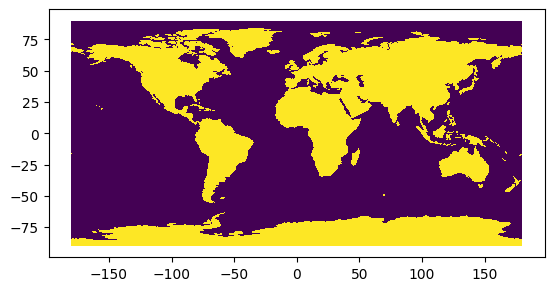

In [9]:
q100_world_gpd.plot(column='mask', cmap='viridis');

### UK medium-resolution grid

Make a regional grid over the UK at 0.25$^{\circ}$ resolution:

In [10]:
q25_UK = qg.QuadGrid(0.25, lon_from=-10, lon_to=5, lat_from=48, lat_to=60)
q25_UK

QuadGrid (0.25) -10<=lon<=5 | 48<=lat<=60

Visualise the effect of applying a geometric mask with different buffering assumptions. The geometric mask is a simplified version of a spatial join, doing a fast point-in-polygon check for all grid centroids. In the left-hand plot (without buffering) we can see that there are areas within the geometry that don't have an associated quadcell. For those cells, this is because the centroid falls outside the geometry, even if some other part of the cell falls inside.

We can reduce this effect by buffering the geometry before doing the point-in-polygon check. A manual amount can be selected, or an optimal amount is automatically used if no `buff` argument is passed to `apply_mask`.

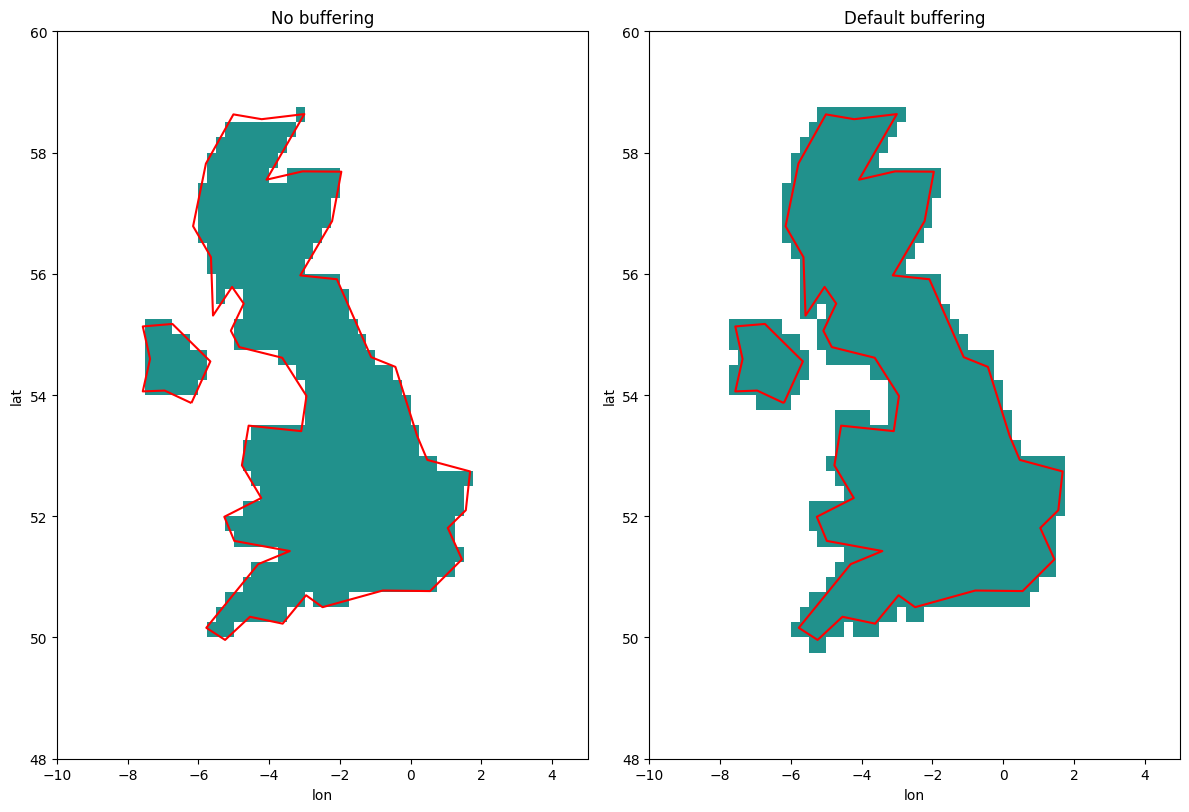

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,8))
q25_UK.apply_mask(uk_geom, buff=0)
q25_UK.to_xarray()['mask'].where(q25_UK.to_xarray()['mask']).plot(ax=ax1, add_colorbar=False)
world[world['iso_a3']=='GBR'].boundary.plot(ax=ax1, color='r')
ax1.set_title('No buffering')
q25_UK.apply_mask(uk_geom, buff=None)
q25_UK.to_xarray()['mask'].where(q25_UK.to_xarray()['mask']).plot(ax=ax2, add_colorbar=False)
world[world['iso_a3']=='GBR'].boundary.plot(ax=ax2, color='r')
ax2.set_title('Default buffering')
fig.tight_layout();

### Distance operations

The `distance()` method calculates the distances from a single point to all grid centroids. For example, the following calculates the distances from Greenwich Observatory of all quadcells on the UK subgrid.

In [12]:
dist = q25_UK.distance(-0.000546, 51.476855)
dist

lat     lon   
48.125  -9.875    799.804641
        -9.625    784.019025
        -9.375    768.324027
        -9.125    752.725496
        -8.875    737.229737
                     ...    
59.875   3.875    964.513949
         4.125    968.525482
         4.375    972.769271
         4.625    977.242235
         4.875    981.941186
Name: distance_km, Length: 2880, dtype: float64

Convert to xarray and use the xarray version of the UK mask to filter out non-land, then plot:

In [13]:
dist_da = dist.to_xarray()

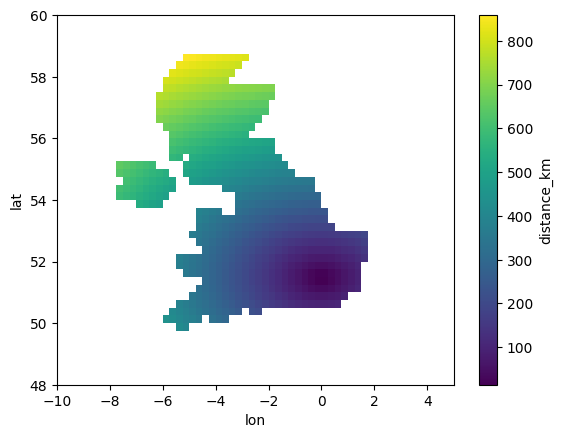

In [14]:
dist_da.where(q25_UK.to_xarray()['mask']).plot();